<a href="https://colab.research.google.com/github/vanshika-hgnis/ML-Explorations-Learnings/blob/main/Multivariate_Time%E2%80%91series_Anomaly_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import math
import gc
import warnings
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("/content/81ce1f00-c3f4-4baa-9b57-006fad1875adTEP_Train_Test.csv")

In [3]:
data.head()

,Time,AFeedStream1,DFeedStream2,EFeedStream3,TotalFeedStream4,RecycleFlowStream8,ReactorFeedRateStream6,ReactorPressurekPagauge,ReactorLevel,ReactorTemperatureDegC,...,EFeedFlowStream3,AFeedFlowStream1,TotalFeedFlowStream4,CompressorRecycleValve,PurgeValveStream9,SeparatorPotLiquidFlowStream10,StripperLiquidProductFlowStream11,StripperSteamValve,ReactorCoolingWaterFlow,CondenserCoolingWaterFlow
0,01-01-2004 00:00,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,01-01-2004 00:01,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,01-01-2004 00:02,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,01-01-2004 00:03,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,01-01-2004 00:04,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [21]:
data['Time'][0]

'01-01-2004 00:00'

In [25]:
data.isnull().sum()

,0
Time,0
AFeedStream1,0
DFeedStream2,0
EFeedStream3,0
TotalFeedStream4,0
RecycleFlowStream8,0
ReactorFeedRateStream6,0
ReactorPressurekPagauge,0
ReactorLevel,0
ReactorTemperatureDegC,0


# Helpers

In [22]:
INPUT_CSV  = "/content/81ce1f00-c3f4-4baa-9b57-006fad1875adTEP_Train_Test.csv"        # <-- set your input file path
OUTPUT_CSV = "/content/output.csv"  # <-- output with 8 new columns

# Time column name and parsing
TIME_COL = "Time"
DAYFIRST = True

# Train/Analysis windows (use ISO to avoid ambiguity)
TRAIN_START   = pd.Timestamp("2004-01-01 00:00")
TRAIN_END     = pd.Timestamp("2004-01-05 23:59")  # 120 hours
ANALYSIS_START= pd.Timestamp("2004-01-01 00:00")
ANALYSIS_END  = pd.Timestamp("2004-01-19 07:59")  # 439 hours typical for this task

# PCA settings
PCA_VARIANCE_TO_KEEP = 0.95     # keep components explaining >=95% variance
MIN_FEATURES_REQUIRED = 7       # dataset should have at least this many numeric features

# Contribution settings
TOP_K_FEATURES = 7
MIN_CONTRIB_PCT = 0.01  # only include features that contribute >=1%
EPS = 1e-8              # small noise to avoid exact zeros
# =======================================================

In [26]:
@dataclass
class DataCheckReport:
    n_rows: int
    n_cols: int
    n_missing: int
    has_duplicates: bool
    freq_is_regular: bool
    inferred_freq: str
    constant_cols: List[str]
    non_numeric_cols: List[str]

def parse_time_index(df: pd.DataFrame, time_col: str, dayfirst: bool = True) -> pd.DataFrame:
    df = df.copy()

    # 1) Clean column names & auto-detect Time column if spacing/BOM issues
    df.columns = df.columns.str.strip().str.replace(r'[\uFEFF\u200B\u200E\u200F]', '', regex=True)
    if time_col not in df.columns:
        cand = [c for c in df.columns if c.lower().strip() == "time"]
        if cand:
            time_col = cand[0]
        else:
            raise KeyError(f"Time column '{time_col}' not found after header cleanup. Columns: {list(df.columns)}")

    # 2) Clean the time strings (strip, remove invisible chars)
    s = (df[time_col].astype(str)
         .str.replace(r'[\uFEFF\u200B\u200E\u200F]', '', regex=True)
         .str.strip())

    # 3) Try multiple parse strategies and merge results
    parsed = pd.to_datetime(s, dayfirst=dayfirst, errors="coerce")  # flexible parser
    if parsed.isna().any():
        for fmt in ("%d-%m-%Y %H:%M", "%d-%m-%Y %H:%M:%S",
                    "%Y-%m-%d %H:%M:%S", "%m/%d/%Y %H:%M",
                    "%Y/%m/%d %H:%M:%S"):
            alt = pd.to_datetime(s, format=fmt, errors="coerce")
            parsed = parsed.fillna(alt)

    # 4) (Optional) Excel serial dates fallback
    bad = parsed.isna()
    if bad.any():
        numeric_mask = s.str.match(r'^\d+(\.\d+)?$')
        if (bad & numeric_mask).any():
            excel = pd.to_numeric(s[bad & numeric_mask], errors="coerce")
            excel_parsed = pd.to_datetime("1899-12-30") + pd.to_timedelta(excel, unit="D")
            parsed.loc[bad & numeric_mask] = excel_parsed

    # 5) If still NaT, print a few examples and drop them (very rare)
    bad = parsed.isna()
    if bad.any():
        bad_vals = s[bad].unique()[:5]
        print(f"[warn] {bad.sum()} rows have unparseable timestamps. Examples: {bad_vals}")
        df = df.loc[~bad].copy()
        parsed = parsed[~bad]

    # 6) Finalize index
    df[time_col] = parsed
    df = df.sort_values(time_col).reset_index(drop=True).set_index(time_col)
    return df

def validate_and_fix(df: pd.DataFrame, time_col: str) -> Tuple[pd.DataFrame, DataCheckReport]:
    non_numeric = [c for c in df.columns if c != time_col and not np.issubdtype(df[c].dtype, np.number)]
    # parse time & set index
    dfi = parse_time_index(df, time_col, dayfirst=DAYFIRST)

    # report
    n_rows, n_cols = dfi.shape
    n_missing = int(dfi.isna().sum().sum())
    has_dupes = not dfi.index.is_unique

    # drop duplicated timestamps keeping first
    if has_dupes:
        dfi = dfi[~dfi.index.duplicated(keep="first")]

    # infer frequency & fix if slightly irregular by linear interpolation
    try:
        inferred = pd.infer_freq(dfi.index)
    except Exception:
        inferred = None

    freq_is_regular = inferred is not None
    if not freq_is_regular:
        # try reindex to 1-min grid and interpolate
        full_index = pd.date_range(dfi.index.min(), dfi.index.max(), freq="T")
        dfi = dfi.reindex(full_index)
        for c in dfi.columns:
            dfi[c] = dfi[c].interpolate(method="time").ffill().bfill()
        inferred = "T"  # enforced to 1-minute grid now
        freq_is_regular = True

    # handle infinite values
    dfi = dfi.replace([np.inf, -np.inf], np.nan)
    # fill missing: forward fill then linear
    dfi = dfi.ffill().bfill()
    if dfi.isna().sum().sum() > 0:
        for c in dfi.columns:
            if dfi[c].isna().any():
                dfi[c] = dfi[c].interpolate().ffill().bfill()

    # constant columns
    numeric_cols = [c for c in dfi.columns if np.issubdtype(dfi[c].dtype, np.number)]
    const_cols = [c for c in numeric_cols if dfi[c].nunique(dropna=True) <= 1]

    report = DataCheckReport(
        n_rows=len(dfi),
        n_cols=len(dfi.columns),
        n_missing=n_missing,
        has_duplicates=has_dupes,
        freq_is_regular=freq_is_regular,
        inferred_freq=inferred if inferred else "unknown",
        constant_cols=const_cols,
        non_numeric_cols=non_numeric
    )
    return dfi, report

def plot_cadence_check(df: pd.DataFrame):
    diffs = df.index.to_series().diff().dropna().dt.total_seconds() / 60.0
    plt.figure(figsize=(8,3))
    plt.plot(diffs.values)
    plt.title("Minute-to-minute interval (should be ~1.0)")
    plt.xlabel("Step")
    plt.ylabel("Minutes")
    plt.tight_layout()
    plt.show()

def plot_sample_timeseries(df: pd.DataFrame, n=4):
    # pick n features by highest variance for a quick look
    variances = df.var().sort_values(ascending=False)
    cols = list(variances.head(n).index)
    plt.figure(figsize=(12,6))
    for c in cols:
        plt.plot(df.index, df[c], label=c, linewidth=1)
    plt.legend(loc="best")
    plt.title("High-variance sample signals")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

def plot_pca_variance(pca: PCA):
    plt.figure(figsize=(6,4))
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumvar)+1), cumvar, marker="o")
    plt.axhline(PCA_VARIANCE_TO_KEEP, linestyle="--")
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.title("PCA variance retained")
    plt.tight_layout()
    plt.show()

def plot_anomaly_timeline(df: pd.DataFrame, score_col: str, train_window: Tuple[pd.Timestamp, pd.Timestamp]):
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df[score_col], linewidth=1)
    plt.title("Anomaly score (0–100)")
    plt.xlabel("Time")
    # Shade training region
    t0, t1 = train_window
    plt.axvspan(t0, t1, color="grey", alpha=0.2, label="Training window")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

def plot_top_anomaly_contribs(contrib_df: pd.DataFrame, top_n_rows: int = 30):
    """
    Heatmap of feature contributions (percent) for the top-N most anomalous rows.
    contrib_df must have per-feature percent contributions (rows aligned to main df).
    """
    # Select top-N rows by total anomaly (sum of contributions)
    totals = contrib_df.sum(axis=1)
    idx = totals.sort_values(ascending=False).head(top_n_rows).index
    mat = contrib_df.loc[idx]

    # Basic heatmap using matplotlib
    plt.figure(figsize=(12, 0.35*top_n_rows + 2))
    plt.imshow(mat.values, aspect="auto", interpolation="nearest")
    plt.colorbar(label="Contribution (%)")
    plt.yticks(range(len(mat.index)), [ts.strftime("%Y-%m-%d %H:%M") for ts in mat.index])
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=90)
    plt.title(f"Feature contribution heatmap for top {top_n_rows} anomalies")
    plt.tight_layout()
    plt.show()


# EDA

== Data Quality Report ==
Rows: 483,840, Cols: 52
Missing (pre-fix): 0
Had duplicates: False
Regular cadence: True (inferred freq: T)
Non-numeric columns (besides Time): []
Constant columns: []


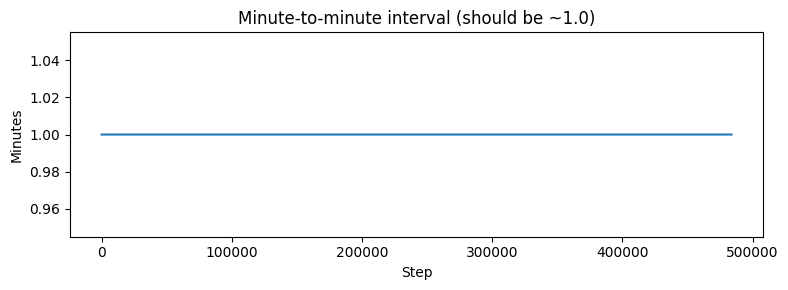

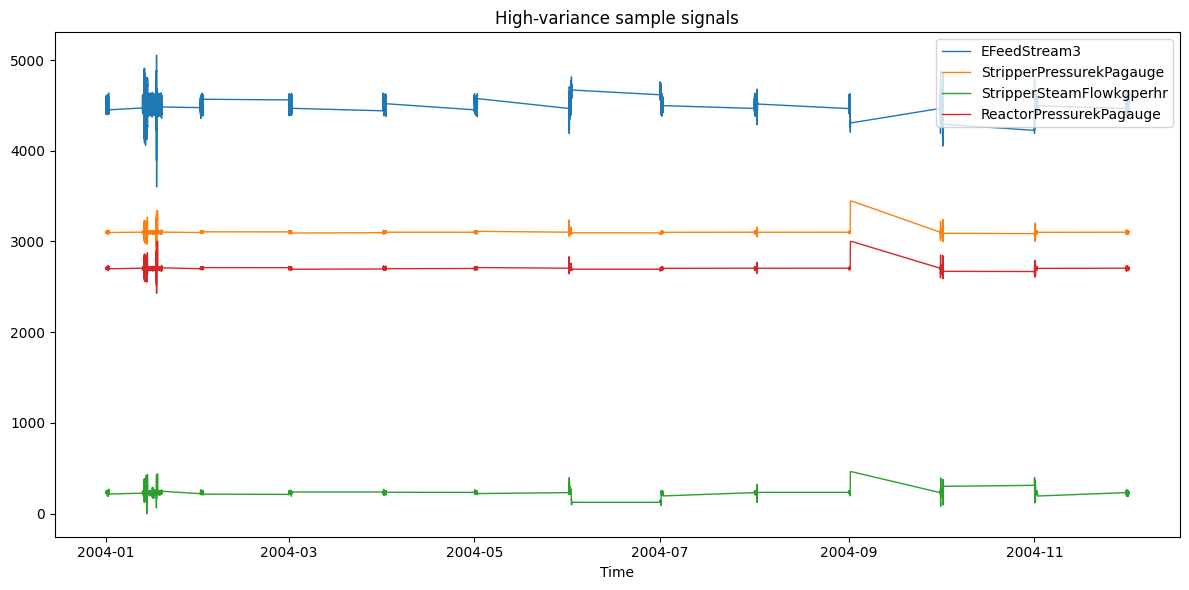

In [27]:
# Load CSV (fast path)
raw = pd.read_csv(INPUT_CSV)

# Validate & clean
dfi, rep = validate_and_fix(raw, TIME_COL)

print("== Data Quality Report ==")
print(f"Rows: {rep.n_rows:,}, Cols: {rep.n_cols}")
print(f"Missing (pre-fix): {rep.n_missing:,}")
print(f"Had duplicates: {rep.has_duplicates}")
print(f"Regular cadence: {rep.freq_is_regular} (inferred freq: {rep.inferred_freq})")
print(f"Non-numeric columns (besides Time): {rep.non_numeric_cols}")
print(f"Constant columns: {rep.constant_cols}")

# Optional: drop constant columns from modeling (kept in output later)
model_df = dfi.drop(columns=rep.constant_cols, errors="ignore")

# Sanity plots
plot_cadence_check(model_df)
plot_sample_timeseries(model_df)


Kept PCA components: 1 of 52


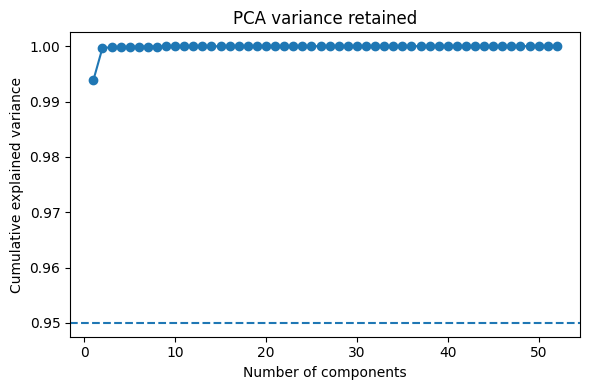

Training-window scores: mean=50.01, max=100.00


In [28]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

def get_feature_matrix(df, start, end):
    feats = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    if len(feats) < MIN_FEATURES_REQUIRED:
        raise ValueError(f"Need >= {MIN_FEATURES_REQUIRED} numeric features; got {len(feats)}.")
    w = df.loc[(df.index >= start) & (df.index <= end), feats].copy()
    if w.empty: raise ValueError("Selected time window returned no rows. Check timestamps.")
    return w, feats

class PcaReconstructionDetector:
    def __init__(self, var_to_keep=0.95):
        self.var_to_keep = var_to_keep
        self.scaler = RobustScaler()
        self.pca = None
        self.train_cols = []

    def fit(self, X):
        self.train_cols = list(X.columns)
        Xs = self.scaler.fit_transform(X.values)
        pca_full = PCA(svd_solver="full", random_state=42).fit(Xs)
        k = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), self.var_to_keep) + 1)
        k = max(1, min(k, Xs.shape[1]))
        self.pca = PCA(n_components=k, svd_solver="full", random_state=42).fit(Xs)
        self.k = k
        return self

    def reconstruction_error(self, X):
        X = X.reindex(columns=self.train_cols)
        Xs = self.scaler.transform(X.values)
        Z = self.pca.transform(Xs)
        Xs_hat = self.pca.inverse_transform(Z)
        resid = Xs - Xs_hat
        per_feat = resid**2
        total = per_feat.sum(axis=1)
        return per_feat, total

# Windows
train_X, feature_cols = get_feature_matrix(model_df, TRAIN_START, TRAIN_END)
analysis_X = model_df.loc[(model_df.index >= ANALYSIS_START) & (model_df.index <= ANALYSIS_END), feature_cols]

# Fit + variance curve
det = PcaReconstructionDetector(PCA_VARIANCE_TO_KEEP).fit(train_X)
print("Kept PCA components:", det.k, "of", len(feature_cols))

tmp_scaler = RobustScaler().fit(train_X.values)
Xs_tmp = tmp_scaler.transform(train_X.values)
pca_tmp = PCA(svd_solver="full").fit(Xs_tmp)
plot_pca_variance(pca_tmp)

# Score
per_feat_err, total_err = det.reconstruction_error(analysis_X)
total_err = total_err + EPS  # avoid exact zeros

# 0–100 score via percentile ranking within the analysis period
scores = pd.Series(total_err, index=analysis_X.index).rank(pct=True) * 100.0

# Contributions (% per feature)
contrib_pct = (per_feat_err / (per_feat_err.sum(axis=1, keepdims=True) + EPS)) * 100.0
contrib_df = pd.DataFrame(contrib_pct, index=analysis_X.index, columns=feature_cols)

# Build output frame with 8 new cols
out = dfi.copy()
out["Abnormality_score"] = np.nan
out.loc[scores.index, "Abnormality_score"] = scores.values

def top_k_names(row, k=TOP_K_FEATURES, min_pct=MIN_CONTRIB_PCT):
    sr = row[row >= (min_pct*100.0)].sort_values(ascending=False)
    names = list(sr.index[:k])
    while len(names) < k: names.append("")
    return names[:k]

top_names = contrib_df.apply(lambda r: pd.Series(top_k_names(r)), axis=1)
top_names.columns = [f"top_feature_{i}" for i in range(1, TOP_K_FEATURES+1)]
for c in top_names.columns:
    out[c] = ""
    out.loc[top_names.index, c] = top_names[c].values

# Sanity check on training period
train_scores = pd.Series(det.reconstruction_error(train_X)[1]).rank(pct=True) * 100.0
print(f"Training-window scores: mean={train_scores.mean():.2f}, max={train_scores.max():.2f}")


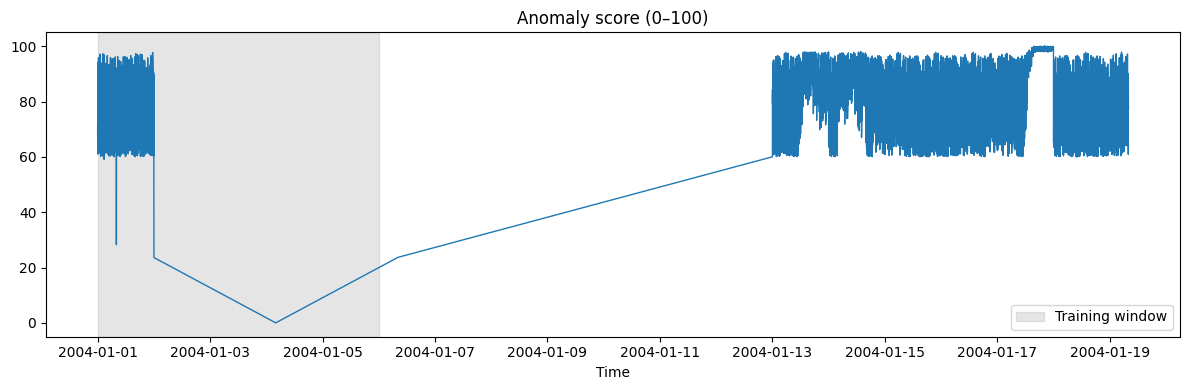

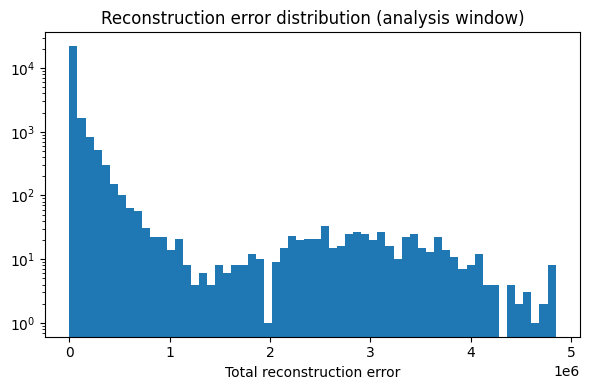

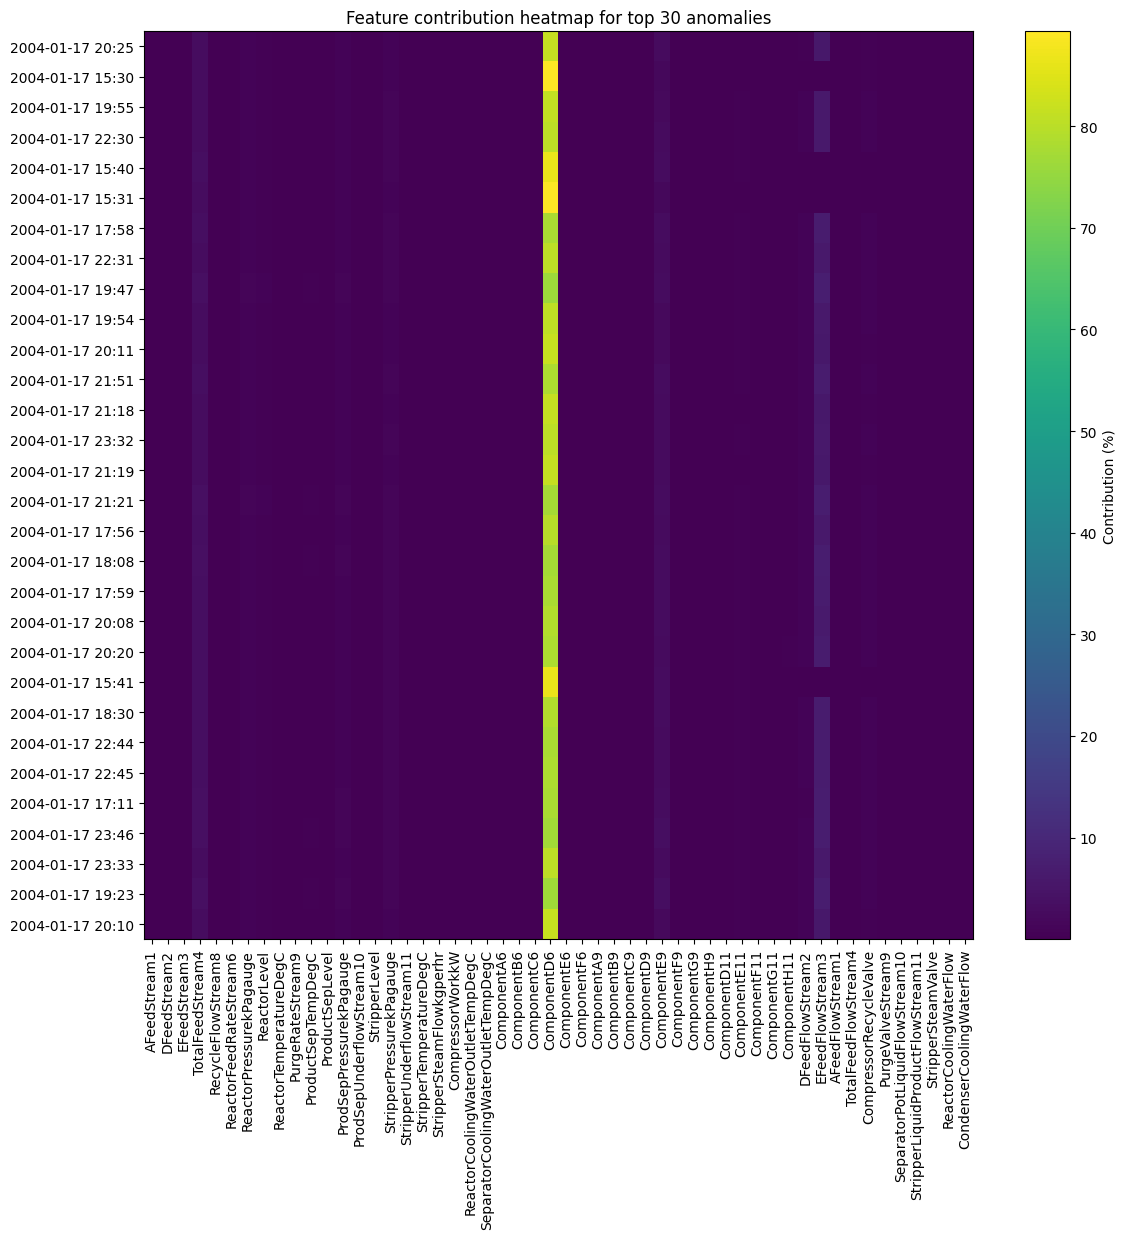

Saved: /content/output.csv


,Abnormality_score,top_feature_1,top_feature_2,top_feature_3,top_feature_4,top_feature_5,top_feature_6,top_feature_7
2004-01-17 20:24:00,100.000000,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,,,
2004-01-17 20:25:00,99.996212,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,,,
2004-01-17 15:30:00,99.992424,ComponentD6,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,,
2004-01-17 20:11:00,99.988636,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,
2004-01-17 20:10:00,99.984848,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,
2004-01-17 15:31:00,99.981061,ComponentD6,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,,
2004-01-17 21:19:00,99.977273,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,
2004-01-17 21:18:00,99.973485,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,
2004-01-17 18:37:00,99.969697,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,
2004-01-17 18:36:00,99.965909,ComponentD6,EFeedFlowStream3,TotalFeedStream4,ComponentE9,StripperPressurekPagauge,,


In [29]:
# Timeline
plot_anomaly_timeline(out, "Abnormality_score", (TRAIN_START, TRAIN_END))

# Error distribution
plt.figure(figsize=(6,4))
plt.hist(total_err, bins=60)
plt.yscale("log")
plt.title("Reconstruction error distribution (analysis window)")
plt.xlabel("Total reconstruction error")
plt.tight_layout()
plt.show()

# Contribution heatmap for top anomalies
plot_top_anomaly_contribs(contrib_df, top_n_rows=30)

# Save modified CSV (original + 8 new columns)
out.reset_index().rename(columns={out.index.name: TIME_COL}).to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV)

# Peek at the worst anomalies
worst_idx = scores.sort_values(ascending=False).head(10).index
display(out.loc[worst_idx, ["Abnormality_score"] + [f"top_feature_{i}" for i in range(1, TOP_K_FEATURES+1)]])
